# MOM6 ANALYSIS - Overview Plot
The key purpose of this notebook will be to create an overview plot of the Study region.
I'd like this overview plot to be a simple, clear picture of the nesting approach, as well as baseline picture of the EAC dynamics and flow fields. 

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf
from xgcm import Grid

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', 
                                       edgecolor='black',
                                       facecolor='gray',
                                       linewidth=0.2)

In [3]:
client = Client()
client

<Client: 'tcp://127.0.0.1:37313' processes=7 threads=14, memory=63.00 GiB>

In [4]:
# set paths to model output
## SRM
eac_003 = '/scratch/v45/jr5971/mom6/archive/eac-003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6/archive/southpac-01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'

Right, so we've got our paths to the model output. Now we want to start by getting velocities from each of the models.

In [5]:
def open_iaf_global(iaf_source = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1", 
                    first_year = 1990,
                    last_year = 1995,
                    input_vars=['u','v','salt','temp','eta_t'],
                    frequency = "daily",
                    decode_times=False):

    year_range = range(first_year, last_year+1)
    filepaths = []
    for year in year_range:
        for var in input_vars:
            pattern = f'{iaf_source}/output*/ocean/ocean-*d-{var}*-1-{frequency}-mean-ym_{year}_*.nc'
            matches = glob.glob(pattern)
            filepaths.extend(matches)
    om2_iaf = xr.open_mfdataset(filepaths, decode_times=decode_times, parallel=True, 
                                chunks={'time':-1, 'yu_ocean':300, 'yt_ocean':300, 'xu_ocean':300, 'xt_ocean':300})
    return om2_iaf, filepaths

## 1. 3D Velocities
This is the first of several notebooks I'll be using to analyse the output of the mom6 regional experiments, also in comparison to the ACCESS-OM2-01 parent model that we use to force the nested models.

In [6]:
# get vars from access;
om2_iaf, _ = open_iaf_global(input_vars=['u','v'],
                            decode_times=True)
om2_iaf

<xarray.Dataset>
Dimensions:         (xu_ocean: 3600, yu_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 2191, nv: 2)
Coordinates:
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 1995-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-u-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1337Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [7]:
def get_mom6_files(path = '/scratch/v45/jr5971/mom6/archive/eac-003/',
                    years = [1990, 1991],
                    input_vars = ['u','v'],
                    frequency = 'daily'):
    filepaths = []
    if years == 'all':
        for var in input_vars:
            pattern = f'{path}/output*/*{var}*.nc'
            matches = glob.glob(pattern)
            filepaths.extend(matches)
        return filepaths  
    else:
        for year in range(years[0], years[1]+1):
            for var in input_vars:
                pattern = f'{path}/output*/{year}*{var}*.nc'
                matches = glob.glob(pattern)
                filepaths.extend(matches)
        return filepaths  

In [8]:
eac_u_files = get_mom6_files(years = 'all', input_vars=['u'])
eac_v_files = get_mom6_files(years = 'all', input_vars=['v'])
eac_u_files.sort();
eac_u = xr.open_mfdataset(eac_u_files[:14])
eac_u

<xarray.Dataset>
Dimensions:     (xh: 645, yh: 759, z_l: 100, z_i: 101, time: 851, nv: 2, xq: 646)
Coordinates:
  * xh          (xh) float64 -219.5 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yh          (yh) float64 -46.18 -46.16 -46.13 ... -26.04 -26.01 -25.98
  * z_l         (z_l) float64 0.2928 0.8999 1.552 ... 5.134e+03 5.324e+03
  * z_i         (z_i) float64 0.0 0.5856 1.214 ... 5.04e+03 5.229e+03 5.419e+03
  * time        (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 -219.5 -219.5 -219.4 ... -198.1 -198.0 -198.0
Data variables:
    volcello    (time, z_l, yh, xh) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    uo          (time, z_l, yh, xq) float32 dask.array<chunksize=(61, 100, 759, 646), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(61, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          eac
    grid_type:      regular
    grid_tile:      N/A

In [9]:
eac_v_files.sort()
eac_v = xr.open_mfdataset(eac_v_files[:14])
eac_v

<xarray.Dataset>
Dimensions:     (xh: 645, yh: 759, z_l: 100, z_i: 101, time: 851, nv: 2, yq: 760)
Coordinates:
  * xh          (xh) float64 -219.5 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yh          (yh) float64 -46.18 -46.16 -46.13 ... -26.04 -26.01 -25.98
  * z_l         (z_l) float64 0.2928 0.8999 1.552 ... 5.134e+03 5.324e+03
  * z_i         (z_i) float64 0.0 0.5856 1.214 ... 5.04e+03 5.229e+03 5.419e+03
  * time        (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * nv          (nv) float64 1.0 2.0
  * yq          (yq) float64 -46.19 -46.17 -46.14 ... -26.02 -25.99 -25.96
Data variables:
    volcello    (time, z_l, yh, xh) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    vo          (time, z_l, yq, xh) float32 dask.array<chunksize=(61, 100, 760, 645), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(61, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          eac
    grid_type:      regular
    grid_tile:      N/A

In [10]:
eac_u_da = eac_u['uo']
eac_v_da = eac_v['vo']
eac = xr.merge([eac_u_da, eac_v_da])
eac

<xarray.Dataset>
Dimensions:  (yh: 759, z_l: 100, time: 851, xq: 646, xh: 645, yq: 760)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.5 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.19 -46.17 -46.14 -46.12 ... -26.02 -25.99 -25.96
Data variables:
    uo       (time, z_l, yh, xq) float32 dask.array<chunksize=(61, 100, 759, 646), meta=np.ndarray>
    vo       (time, z_l, yq, xh) float32 dask.array<chunksize=(61, 100, 760, 645), meta=np.ndarray>
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

In [11]:
sthpac_u_files = get_mom6_files(path=sthpac_01, years=[1990,1993],
                                input_vars=['u'])
sthpac_u = xr.open_mfdataset(sthpac_u_files)

In [12]:
sthpac_v_files = get_mom6_files(path=sthpac_01, years=[1990,1993],
                                input_vars=['v'])
sthpac_v = xr.open_mfdataset(sthpac_v_files)

In [13]:
sthpac_u_da = sthpac_u['uo']
sthpac_v_da = sthpac_v['vo']
sthpac = xr.merge([sthpac_u_da, sthpac_v_da])
sthpac

<xarray.Dataset>
Dimensions:  (yh: 705, z_l: 75, time: 1461, xq: 426, xh: 425, yq: 706)
Coordinates:
  * yh       (yh) float64 -49.96 -49.9 -49.83 -49.77 ... 12.16 12.26 12.35 12.45
  * z_l      (z_l) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time     (time) object 1990-01-01 12:00:00 ... 1993-12-31 12:00:00
  * xq       (xq) float64 -220.0 -219.9 -219.8 -219.7 ... -177.7 -177.6 -177.5
  * xh       (xh) float64 -219.9 -219.8 -219.7 -219.6 ... -177.7 -177.6 -177.5
  * yq       (yq) float64 -49.99 -49.93 -49.87 -49.8 ... 12.21 12.3 12.4 12.5
Data variables:
    uo       (time, z_l, yh, xq) float32 dask.array<chunksize=(31, 75, 705, 426), meta=np.ndarray>
    vo       (time, z_l, yq, xh) float32 dask.array<chunksize=(31, 75, 706, 425), meta=np.ndarray>
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

In [14]:
# subset global to some region just bigger than the sthpac model...
sthpac_idx = {'W':sthpac.xh.min().values, 'E':sthpac.xh.max().values, 
              'S':sthpac.yh.min().values, 'N':sthpac.yh.max().values}
eac_idx = {'W':eac.xh.min().values, 'E':eac.xh.max().values,
           'S':eac.yh.min().values, 'N':eac.yh.max().values}
om2_subset = om2_iaf.sel(xu_ocean=slice(sthpac_idx['W'] - 30, sthpac_idx['E']+50),
                                          yu_ocean = slice(sthpac_idx['S']-30, sthpac_idx['N']+30))

### Regrid using `xgcm` to get u and v on same grid

In [15]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac.xh.min().values, 2), np.round(eac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac.xq.min().values, 2), np.round(eac.yq.min().values,2))

Bottom left centre points:  -219.48 -46.18
Bottom left CORNER points:  -219.5 -46.19


So corner points are to the south-west of centre points - this makes a **symmetric** grid, meaning there is one extra corner axis in both horizontal directions. For `xgcm`, this can cause problems so in this case, we are just going to snip this first row and column off. 

In [16]:
# Set up dictionary of datasets for ease of processing
da_dict = {'eac':eac,'sthpac':sthpac}

In [17]:
def make_grids_symmetric():
    '''
    Used as a precursor to `xgcm` for velocity data
    Expects a dictionary of data arrays that is then updated based on the 
    south-west corner points.
    '''
    global da_dict
    
    for name, da in da_dict.items():
        if 'xq' in da.coords:
            print(f'xq in coords for {name}')
            da = da.isel(xq=slice(1,len(da.xq)))
            # da_dict[name] = da
        else:
            print(f'{name} is aligned with centre (xh)')
            
        if 'yq' in da.coords:
            print(f'yq in coords for {name}')
            da = da.isel(yq=slice(1,len(da.yq)))
        else:
            print(f'{name} is aligned with centre (yh)')
        da_dict[name] = da    

In [18]:
make_grids_symmetric()

xq in coords for eac
yq in coords for eac
xq in coords for sthpac
yq in coords for sthpac


In [19]:
# EAC
eac = da_dict['eac']
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac.xh.min().values, 2), np.round(eac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac.xq.min().values, 2), np.round(eac.yq.min().values,2))

Bottom left centre points:  -219.48 -46.18
Bottom left CORNER points:  -219.47 -46.17


In [20]:
# EAC
sthpac = da_dict['sthpac']
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(sthpac.xh.min().values, 2), np.round(sthpac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(sthpac.xq.min().values, 2), np.round(sthpac.yq.min().values,2))

Bottom left centre points:  -219.95 -49.96
Bottom left CORNER points:  -219.9 -49.93


### Define the xgcm grid

In [21]:
eac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/eac-003/output000/19900101.ocean_static.nc')
sthpac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/southpac-01/output000/19900101.ocean_static.nc')

static_dict = {'eac':eac_static, 'sthpac':sthpac_static}

for name, da in da_dict.items():
    da['dxt'] = static_dict[name]['dxt'] # Add dx grid thicknesses to data array
    da['dyt'] = static_dict[name]['dyt'] # Add dy grid thicnkesses to data array
    da_dict[name] = da
da_dict['eac'] # new eac data array with u, v, dxt, dyt

<xarray.Dataset>
Dimensions:  (yh: 759, z_l: 100, time: 851, xq: 645, xh: 645, yq: 759)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.17 -46.14 -46.12 -46.1 ... -26.02 -25.99 -25.96
Data variables:
    uo       (time, z_l, yh, xq) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    vo       (time, z_l, yq, xh) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    dxt      (yh, xh) float32 ...
    dyt      (yh, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

In [22]:
metrics = { # set dictionary with metrics for new Grid - e.g., calling 'X' means dxt, calling 'Y' means dyt
    ('X',) : ['dxt'], # X distances
    ('Y',) : ['dyt'] # Y  distances
}
coords = {'X' : {'center':'xh', 'right':'xq'}, # Another dictionary - setting 'X' to be it's own dictionary of center/right
          'Y' : {'center':'yh', 'right':'yq'} }

eac_grid = Grid(da_dict['eac'], coords=coords, metrics=metrics, periodic=False)
sthpac_grid = Grid(da_dict['sthpac'], coords=coords, metrics=metrics, periodic=False)
grid_dict = {'eac':eac_grid, 'sthpac':sthpac_grid}

grid_dict['eac']    

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

In [34]:
eac_u_3d = eac['uo']
eac_u_top100 = eac_u_3d.sel(z_l=slice(0, 100)).sum(dim='z_l')
eac_u_top100

<xarray.DataArray 'uo' (time: 851, yh: 759, xq: 645)>
dask.array<sum-aggregate, shape=(851, 759, 645), dtype=float32, chunksize=(62, 759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

In [35]:
def integrate_depth(da, mindepth, maxdepth):
    try:
        da_integ = da.sel(z_l=slice(mindepth, maxdepth)).sum('z_l')
    except:
        da_integ = da.sel(st_ocean=slice(mindepth, maxdepth)).sum('st_ocean')
    return da_integ
                          

### Choose variables for plotting
Now I want to plot the depth-integrated velocities. How do I get these?

In [45]:
da_dict['om2'] = om2_subset

In [47]:
da_dict.keys()

dict_keys(['eac', 'sthpac', 'om2'])

In [48]:
ds_dict = da_dict

The following loop goes through each model that we have saved in `ds_dict` and gets the depth integrated velocities over the first 100 m. The result is then saved in each model output of the same dictionary. 

In [49]:
for name, model in ds_dict.items():
    # get u and v from ds
    try:
        u_depthInt = model['uo'].sel(z_l=slice(0,100)).sum('z_l')
        v_depthInt = model['vo'].sel(z_l=slice(0,100)).sum('z_l')
    except:
        u_depthInt = model['u'].sel(st_ocean=slice(0,100)).sum('st_ocean')
        v_depthInt = model['v'].sel(st_ocean=slice(0,100)).sum('st_ocean')
    model['u_depthInt'] = u_depthInt
    model['v_depthInt'] = v_depthInt
    ds_dict[name] = model
    

Now to make things easier to plot, let's extract the desired variables from the respective dictionaries

In [51]:
# extract datasets from dataset dictionary
eac = ds_dict['eac']
sthpac = ds_dict['sthpac']
om2 = ds_dict['om2']

# extract plotting variables from dataset
eac_v = eac['v_depthInt']
eac_u = eac['u_depthInt']
sthpac_v = sthpac['v_depthInt']
sthpac_u = sthpac['u_depthInt']
om2_v = om2['v_depthInt']
om2_u = om2['u_depthInt']

#### Offset v output from MOM6 to u-grid (yh, xq)

In [52]:
# Interpolate v onto the u grid
eac_v = grid_dict['eac'].interp(eac_v, axis=['X', 'Y'])
sthpac_v = grid_dict['sthpac'].interp(sthpac_v, axis=['X','Y'])
eac_v

<xarray.DataArray 'v_depthInt' (time: 851, yh: 759, xq: 645)>
dask.array<transpose, shape=(851, 759, 645), dtype=float32, chunksize=(62, 759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

Now the u and v points are all on the same grid for all three models. Let's now rename these to a simple `lat`, `lon`. 

In [54]:
# rename coords from yh, xq to lat, lon
vel_dict = {'eac_v':eac_v, 'eac_u':eac_u, 'sthpac_v':sthpac_v, 'sthpac_u':sthpac_u, 'om2_v':om2_v, 'om2_u':om2_u}
for name, da in vel_dict.items():
    try:
        da = da.rename({'yh':'lat','xq':'lon'})
    except:
        da = da.rename({'yu_ocean':'lat','xu_ocean':'lon'})
    vel_dict[name] = da
    

Right, so there's a fair bit of fiddling around when dealing with the three different grids. Surely we'll have to simplify things pretty soon...
### Using xgcm
Now we're going to regrid to hopefully make things easier for plotting the streamplots

In [55]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [56]:
def regrid_for_streamplot(u, v, res):
    # Create target grid that has equal spaced points (a requirement for streamplot)
    x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
    y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
    X_target, Y_target = np.meshgrid(x_target, y_target)
    
    # Create regridder object
    regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')
    
    # regrid data
    u_target = regridder(u)
    v_target = regridder(v)
    
    return x_target, y_target, u_target, v_target

In [57]:
%%time
x, y, u, v = regrid_for_streamplot(u=vel_dict['sthpac_u'], v=vel_dict['sthpac_v'],
                                       res=2)

CPU times: user 7.97 s, sys: 1.03 s, total: 9 s
Wall time: 8.26 s


In [62]:
x += 360

CPU times: user 3.79 s, sys: 218 ms, total: 4.01 s
Wall time: 3.49 s


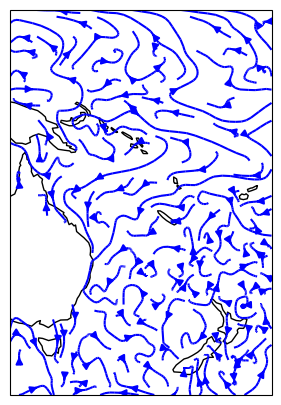

In [63]:
%%time
# x, y, u, v = regrid_for_streamplot(u=vel_dict['sthpac_u'], v=vel_dict['sthpac_v'],
#                                        res=2)
# plot streamplot for time = 100
# u_snap = u.isel(time=100).compute()
# v_snap = v.isel(time=100).compute()
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.streamplot(x, y, u_snap, v_snap, density=1, color='b', transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, color='green')
ax.coastlines()

#### Plot temporal average

In [64]:
%%time
# take average 
u_av = u[:700,:].mean('time').compute()
v_av = v[:700,:].mean('time').compute()
speed = np.sqrt(u[:700,:]**2 + v[:700,:]**2)
speed_av = speed.mean('time').compute()

CPU times: user 21.9 s, sys: 9.3 s, total: 31.2 s
Wall time: 2min 18s


In [70]:
x.min()

140.10000000000338

In [71]:
speed_av

<xarray.DataArray (y: 352, x: 212)>
array([[6.1138268, 6.034383 , 5.681639 , ..., 6.090243 , 6.2932706,
        6.626407 ],
       [6.2292633, 6.080289 , 5.688577 , ..., 5.739041 , 6.1386433,
        6.530064 ],
       [4.977352 , 4.7118263, 4.2743363, ..., 5.716407 , 6.251212 ,
        6.234101 ],
       ...,
       [5.0747843, 5.187495 , 5.288411 , ..., 3.953247 , 4.234756 ,
        3.9416838],
       [5.0327296, 5.181342 , 5.2885423, ..., 4.3907275, 4.3852286,
        4.043103 ],
       [5.156983 , 5.3464336, 5.4667416, ..., 5.650285 , 5.155205 ,
        4.417164 ]], dtype=float32)
Coordinates:
    lat      (y, x) float64 -49.96 -49.96 -49.96 -49.96 ... 12.45 12.45 12.45
    lon      (y, x) float64 -219.9 -219.7 -219.5 -219.3 ... -177.9 -177.7 -177.5
Dimensions without coordinates: y, x

In [72]:
len(x)

212

In [73]:
speed_av.shape

(352, 212)

Text(0.5, 1.0, 'Average Velocity off SE Tas')

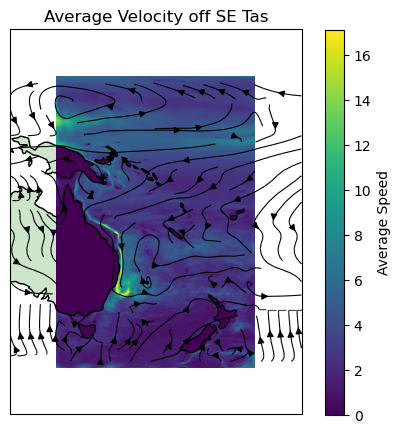

In [74]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min()-10, x.max()+10, y.min()-10, y.max()+10], crs=ccrs.PlateCarree())

# Plot the data
pc = ax.pcolormesh(x, y, speed_av,transform=ccrs.PlateCarree())
ax.streamplot(x, y, u_av, v_av, density=1, color='k', broken_streamlines=True,
              arrowsize=1, linewidth=.8, transform=ccrs.PlateCarree())


# Add land and coastlines
ax.add_feature(cfeature.LAND, color='green', zorder=0, alpha=0.2)
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Average Speed')

ax.set_title('Average Velocity off SE Tas')

So, what's going wrong here - The average speed is good, but the streamlines are all over the place. 

Text(0.5, 1.0, 'Average Velocity off SE Tas')

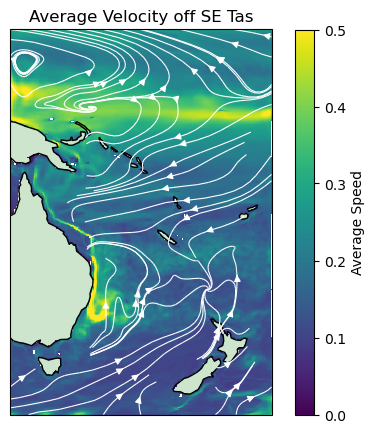

In [50]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())

# Plot the data
pc = ax.pcolormesh(x, y, speed_av, vmin=0, vmax=0.5, transform=ccrs.PlateCarree())
ax.streamplot(x, y, u_av, v_av, density=.5, color='w', broken_streamlines=False,
              arrowsize=1, linewidth=.8, transform=ccrs.PlateCarree())


# Add land and coastlines
ax.add_feature(cfeature.LAND, color='green', zorder=0, alpha=0.2)
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Average Speed')

ax.set_title('Average Velocity off SE Tas')

In [51]:
%%time
x_eac, y_eac, u_eac, v_eac = regrid_for_streamplot(u=vel_dict['eac_u'], v=vel_dict['eac_v'],
                                       res=2)
# take average 
u_av_eac = u_eac[:700,:].mean('time').compute()
v_av_eac = v_eac[:700,:].mean('time').compute()
speed_eac = np.sqrt(u_eac[:700,:]**2 + v_eac[:700,:]**2)
speed_av_eac = speed_eac.mean('time').compute()

CPU times: user 38.8 s, sys: 11.5 s, total: 50.3 s
Wall time: 3min 6s


CPU times: user 13.6 s, sys: 287 ms, total: 13.9 s
Wall time: 13.4 s


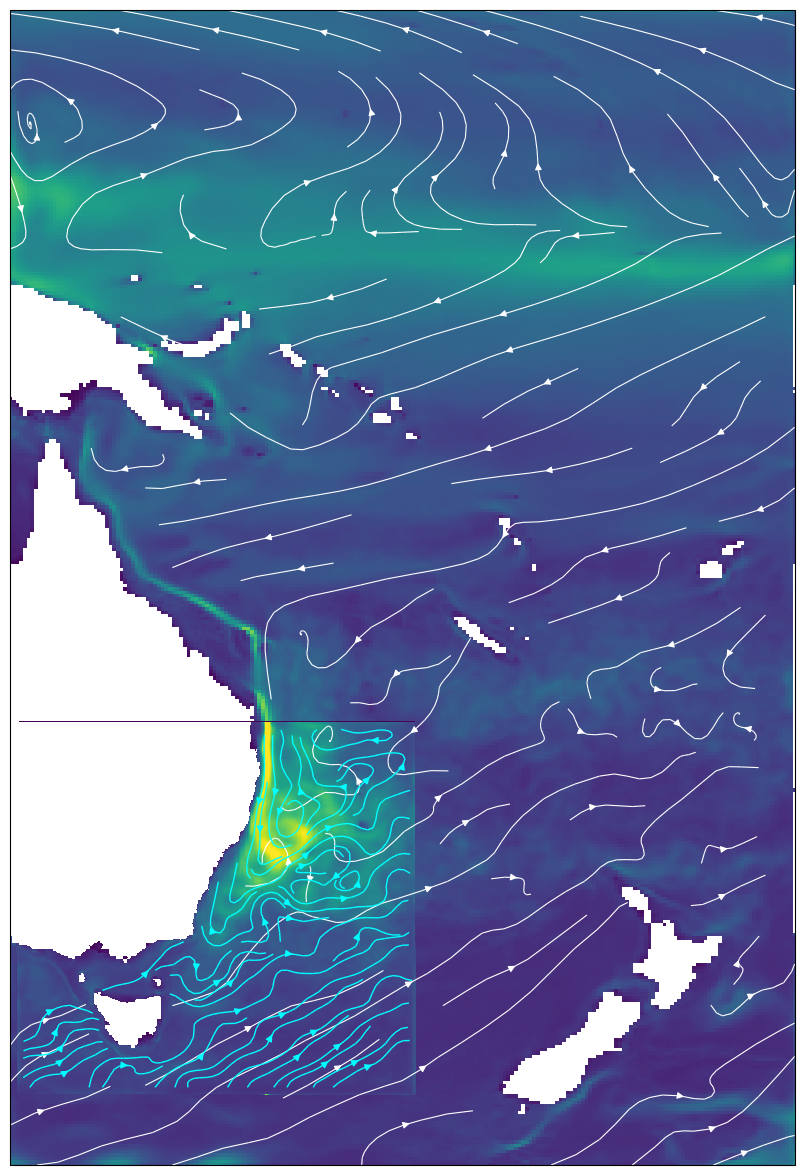

In [64]:
%%time
plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())

# Plot the data
pc = ax.pcolormesh(x, y, speed_av, vmin=0, vmax=0.8, transform=ccrs.PlateCarree())
ax.streamplot(x, y, u_av, v_av, density=1, color='w', broken_streamlines=True,
              arrowsize=1, linewidth=.8, transform=ccrs.PlateCarree())
pc_eac = ax.pcolormesh(x_eac, y_eac, speed_av_eac, vmin=0, vmax=0.8, transform=ccrs.PlateCarree())
ax.streamplot(x_eac, y_eac, u_av_eac, v_av_eac, density=4, color='aqua', broken_streamlines=True,
              arrowsize=1, linewidth=1, transform=ccrs.PlateCarree())



# Add land and coastlines
# ax.add_feature(cfeature.LAND, color='green', zorder=0, alpha=0.2)
# ax.coastlines()

# # Add a colorbar
# cbar = plt.colorbar(pc, ax=ax, orientation='vertical', pad=0.05)
# cbar.set_label('Average Speed')

# ax.set_title('Average Velocity off SE Tas')

Hopefully after a longer time period this average might converge on the picture we understand - for no though, 

#### Add depth contour to plot

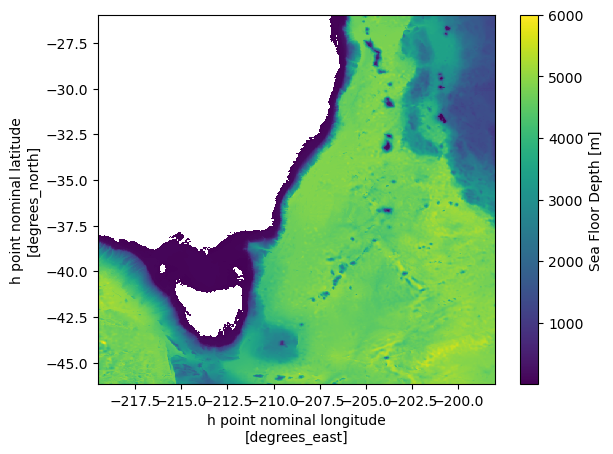

In [105]:
eac_depth = eac_static['deptho']
eac_depth.plot()

Firstly, let's start with a simple test of the velocities for the eac, and just select the first timestep

In [28]:
sparseness = 1
eac_u_sparse = vel_dict['eac_u'][0, ::sparseness, ::sparseness]
eac_v_sparse = vel_dict['eac_v'][0, ::sparseness, ::sparseness]

In [30]:
# set resolution of new grid
res = 200 # grid-cells wide/high
# Go through regridding to get streamlines for sthpac and access...
sthpac_u = vel_dict['sthpac_u']
sthpac_v = vel_dict['sthpac_v']
# adjust chunk size to avoid regridder error later on
om2_u = vel_dict['om2_u'].chunk({'lat':-1,'lon':-1})
om2_v = vel_dict['om2_v'].chunk({'lat':-1,'lon':-1}) 

# target grid for sthpac
x_t_sthpac = np.linspace(sthpac_u['lon'].min(), sthpac_u['lon'].max(), res)
y_t_sthpac = np.linspace(sthpac_u['lat'].min(), sthpac_u['lat'].max(), res)
X_t_sthpac, Y_t_sthpac = np.meshgrid(x_t_sthpac, y_t_sthpac)

# target grid for access
x_t_om2 = np.linspace(om2_u['lon'].min(), om2_u['lon'].max(), res)
y_t_om2 = np.linspace(om2_u['lat'].min(), om2_u['lat'].max(), res)
X_t_om2, Y_t_om2 = np.meshgrid(x_t_om2, y_t_om2)

In [31]:
# Define the target grid for interpolation
x_target = np.linspace(eac_u_sparse['lon'].min(), eac_u_sparse['lon'].max(), res)
y_target = np.linspace(eac_u_sparse['lat'].min(), eac_u_sparse['lat'].max(), res)
X_target, Y_target = np.meshgrid(x_target, y_target)

In [32]:
%%time
# Set up regridders
eac_regridder = xesmf.Regridder(eac_u_sparse, {'lon':X_target, 'lat':Y_target}, 'bilinear')
sthpac_regridder = xesmf.Regridder(sthpac_u, {'lon':X_t_sthpac, 'lat':Y_t_sthpac}, 'bilinear')
om2_regridder = xesmf.Regridder(om2_u, {'lon':X_t_om2, 'lat':Y_t_om2}, 'bilinear')

CPU times: user 34 s, sys: 2.73 s, total: 36.7 s
Wall time: 31.7 s


In [33]:
# regrid all velocity data to orthogonal grid
# eac velocity
u_t_eac = eac_regridder(eac_u_sparse)
v_t_eac = eac_regridder(eac_v_sparse)
# sthpac velocity
u_t_sthpac = sthpac_regridder(sthpac_u) # u-target sthpac
v_t_sthpac = sthpac_regridder(sthpac_v) # v-target sthpac
# om2 velocity
u_t_om2 = om2_regridder(om2_u) # u-target om2
v_t_om2 = om2_regridder(om2_v) # v-target om2

### Small plots of each different option
Here, rather than try to plot the different things all on one plot, let's just plot each different option which will then make it easier to decide which one to go with.

In [50]:
def regrid_for_streamplot(u, v, res):
    # Create target grid that has equal spaced points (a requirement for streamplot)
    x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
    y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
    X_target, Y_target = np.meshgrid(x_target, y_target)
    
    # Create regridder object
    regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')
    
    # regrid data
    u_target = regridder(u)
    v_target = regridder(v)
    
    return x_target, y_target, u_target, v_target

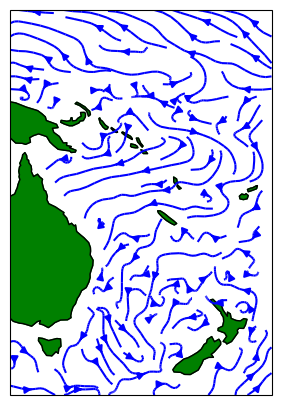

In [61]:
x, y, u, v = regrid_for_streamplot(u=vel_dict['sthpac_u'], v=vel_dict['sthpac_v'],
                                       res=2)
# plot streamplot for time = 100
u_snap = u.isel(time=100)
v_snap = v.isel(time=100)
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.streamplot(x, y, u_snap, v_snap, density=1, color='b', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='green')
ax.coastlines()

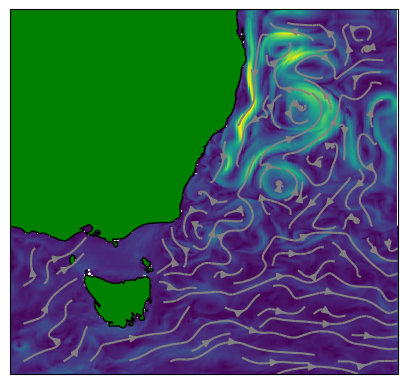

In [65]:
x, y, u, v = regrid_for_streamplot(u=vel_dict['eac_u'], v=vel_dict['eac_v'],
                                       res=2)
print(u.shape)
# plot streamplot for time = 100
u_snap = u.isel(time=100)
v_snap = v.isel(time=100)

speed = np.sqrt(u_snap**2 + v_snap**2)
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.pcolormesh(x, y, speed, transform=ccrs.PlateCarree())
ax.streamplot(x, y, u_snap, v_snap, density=1, color='grey', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, color='green')
ax.coastlines()

Zoom in on Tassie and see what the above plot would look like...

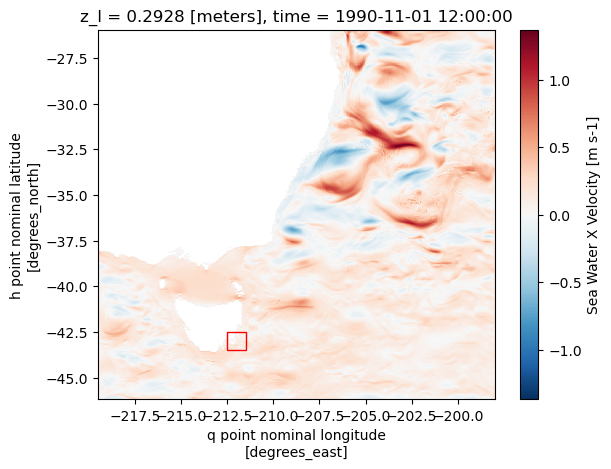

In [90]:
ax=plt.axes()
eac_u.isel(time=0).plot(ax=ax)
tas_idx = {'W':-212.5, 'E':-211.5, 'S':-43.5, 'N':-42.5}
tas_box = patches.Rectangle((tas_idx['W'], tas_idx['S']), (tas_idx['E']-tas_idx['W']),
                            (tas_idx['N']-tas_idx['S']), color='r', fill=None)
ax.add_patch(tas_box)

(851, 41, 30)
CPU times: user 1.95 s, sys: 659 ms, total: 2.61 s
Wall time: 14.3 s


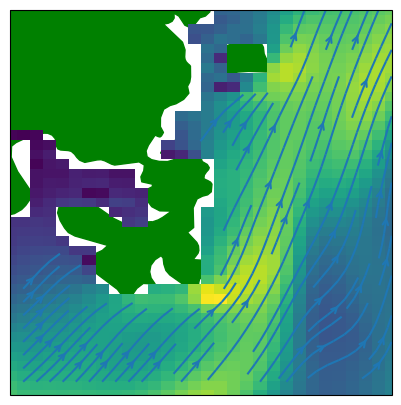

In [93]:
%%time
x, y, u, v = regrid_for_streamplot(u=vel_dict['eac_u'].sel(lon=slice(tas_idx['W'],tas_idx['E']),
                                                           lat=slice(tas_idx['S'], tas_idx['N'])),
                                   v=vel_dict['eac_v'].sel(lon=slice(tas_idx['W'],tas_idx['E']),
                                                           lat=slice(tas_idx['S'],tas_idx['N'])),
                                   res=1)
print(u.shape)
# # plot streamplot for time = 100
snap = 500
u_snap = u.isel(time=snap)
v_snap = v.isel(time=snap)

speed = np.sqrt(u_snap**2 + v_snap**2)
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.pcolormesh(x, y, speed, transform=ccrs.PlateCarree())
ax.streamplot(x, y, u_snap, v_snap, density=1, color=None, arrowstyle='->', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, color='green')
# ax.coastlines()

In [92]:
%%time
# take average 
u_av = u[:700,:].mean('time').compute()
v_av = v[:700,:].mean('time').compute()
speed = np.sqrt(u[:700,:]**2 + v[:700,:]**2)
speed_av = speed.mean('time').compute()

CPU times: user 7.35 s, sys: 5.5 s, total: 12.8 s
Wall time: 1min 18s


Text(0.5, 1.0, 'Average Velocity off SE Tas')

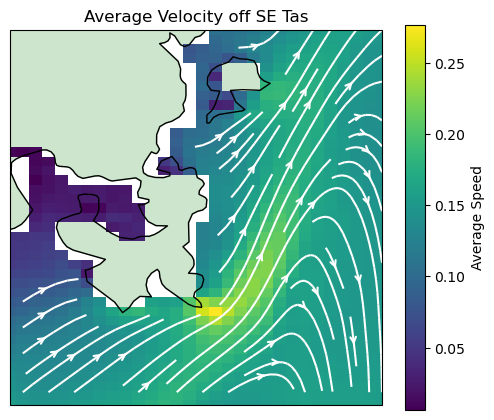

In [102]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())

# Plot the data
pc = ax.pcolormesh(x, y, speed_av, transform=ccrs.PlateCarree())
ax.streamplot(x, y, u_av, v_av, density=1, color='w', broken_streamlines=True,
              arrowstyle='->', transform=ccrs.PlateCarree())

# Add land and coastlines
ax.add_feature(cfeature.LAND, color='green', zorder=0, alpha=0.2)
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Average Speed')

ax.set_title('Average Velocity off SE Tas')

Something I have to understand and convey to others is that this model still has grid spacings of 2.5 km, whilst the coastal bays and inlets are even smaller than this - hence we aren't aiming to resolve the processes right up to the beach. We are aiming for a model that captures the interaction between the large-scale processes, and the shelf circulation. Let's get the isobath in these plots to understand how many grid-cells we are actually resolving on the shelf.

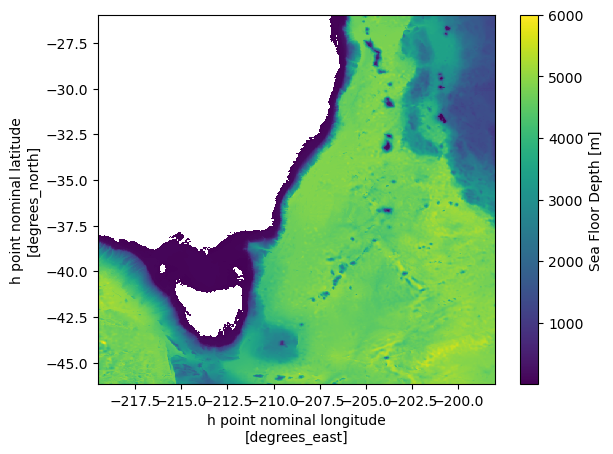

In [105]:
eac_depth = eac_static['deptho']
eac_depth.plot()

In [106]:
import matplotlib.colors as mcolors

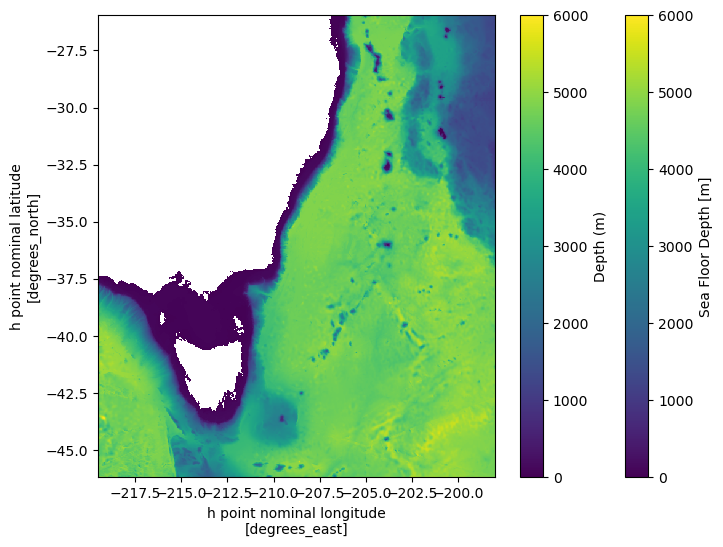

In [109]:
# create custom colormap
cmap = plt.cm.viridis
cmap_over = plt.cm.Purples

# Normalise colormap
norm = mcolors.Normalize(vmin=0, vmax=6000)

# create a figure
plt.figure(figsize=(8,6))
ax = plt.axes()
eac_depth.plot.imshow(ax = ax, cmap=cmap, norm=norm)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, orientation='vertical')
cbar.set_label('Depth (m)')

In [117]:
import matplotlib.cbook as cbook
from matplotlib import cm
# import cmocean as cm

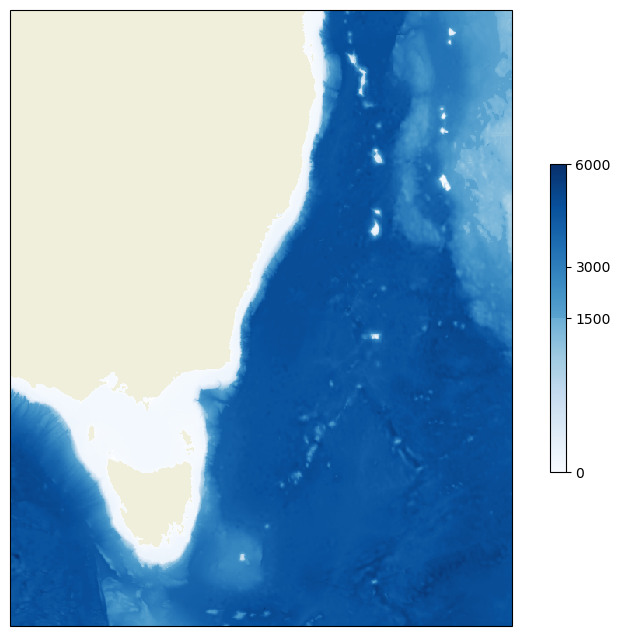

In [142]:
plt.figure(figsize=(10,8))
ax=plt.axes(projection=ccrs.PlateCarree())
colors_shelf = plt.cm.Blues(np.linspace(0, 0.5, 256))
colors_offshelf = plt.cm.Blues(np.linspace(0.55,1,256))
all_colors = np.vstack((colors_shelf, colors_offshelf))

terrain_map = mcolors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

divnorm = mcolors.TwoSlopeNorm(vmin=0, vcenter=1500, vmax=6000)

pcm = eac_depth.plot(ax=ax, rasterized=True, norm=divnorm,
                     cmap = terrain_map, shading='auto',
                    add_colorbar=False)

ax.set_aspect(1 / np.cos(np.deg2rad(40)))
cb = plt.colorbar(pcm, shrink=0.5)
cb.set_ticks([0, 1500, 3000, 6000])

ax.add_feature(cfeature.LAND)

So,  things aren't really doing what I am expecting them to. 

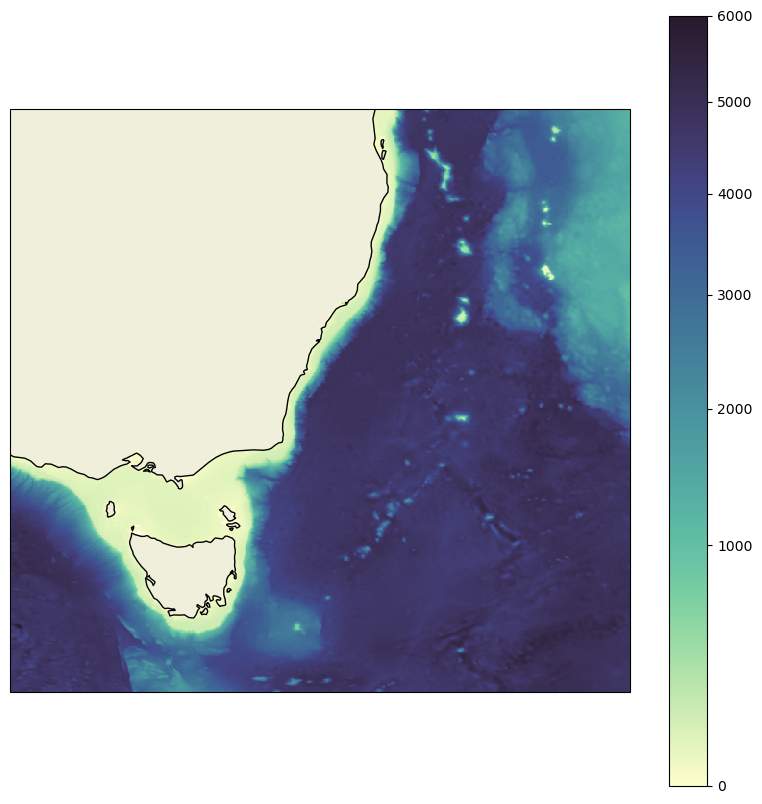

In [126]:
plt.figure(figsize=(10,8))
ax=plt.axes(projection=ccrs.PlateCarree())
pcm = eac_depth.plot(ax=ax, norm=mcolors.PowerNorm(gamma=0.65),
                    cmap=cm.cm.deep, transform=ccrs.PlateCarree(), add_colorbar=False)
plt.colorbar(pcm, ax=ax)
ax.add_feature(cfeature.LAND)
ax.coastlines()

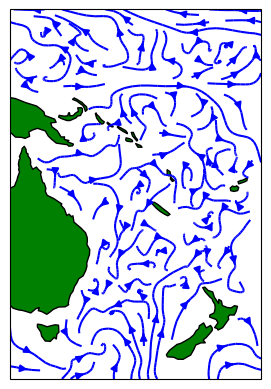

In [42]:
# sthpac streamplot
day = '1991-01-01'
u = u_t_sthpac.sel(time=day).data.squeeze()
v = v_t_sthpac.sel(time=day).data.squeeze()

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-210))
extent = [x_t_sthpac.min(), x_t_sthpac.max(), y_t_sthpac.min(), y_t_sthpac.max()]
ax.set_extent(extent, crs=ccrs.PlateCarree())

ax.streamplot(x_t_sthpac, y_t_sthpac, u, v, density=1, color='b', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='green')
ax.coastlines()

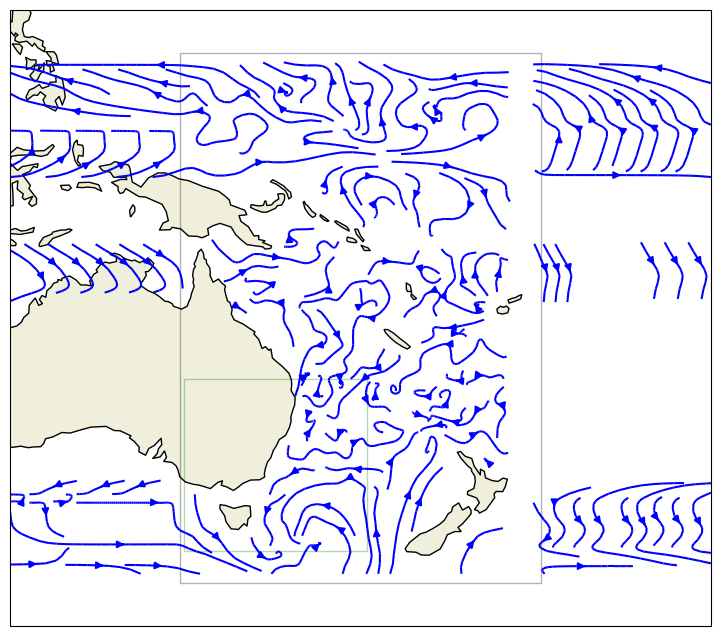

In [37]:
day = '1991-01-01'
# select day from data
u_sp = u_t_sthpac.sel(time=day).data.squeeze()
v_sp = v_t_sthpac.sel(time=day).data.squeeze()

# Create the streamline plot
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-210))

extent = [sthpac_idx['W']-20, sthpac_idx['E']+20, sthpac_idx['S']-5, sthpac_idx['N']+5]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# ax.streamplot(X_t_om2, Y_t_om2, u_t_om2.values, v_t_om2.values, density=2, color='grey', 
#               alpha=0.5, transform=ccrs.PlateCarree())
ax.streamplot(X_t_sthpac, Y_t_sthpac, u_sp, v_sp, density=2, color='b', transform=ccrs.PlateCarree())
# om2_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
# sthpac_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
# eac_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

box1 = patches.Rectangle((sthpac_idx['W'], sthpac_idx['S']), (sthpac_idx['E']-sthpac_idx['W']), 
                        (sthpac_idx['N']-sthpac_idx['S']), fill=None, transform=ccrs.PlateCarree(),
                        alpha=0.3)
box2 = patches.Rectangle((eac_idx['W'], eac_idx['S']), (eac_idx['E']-eac_idx['W']), 
                        (eac_idx['N']-ea
                         c_idx['S']), color='g', fill=None, transform=ccrs.PlateCarree(),
                        alpha=0.3)

ax.add_patch(box1); ax.add_patch(box2)
ax.add_feature(cfeature.LAND, zorder=0)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
ax.coastlines()

Okay, now that I've got this pretty cool capability, how do I want to use it to make an aesthetically appealing overview plot. What is the main benefit of having the streamlines? 
- Streamlines can give a good overview of the general circulation patterns in a manner that is fairly easy to understand --> Based on this, it might be good to have the 10th degree LRM with streamlines, and have these overlaying the high-res model. But then have a finer resolution shading of either temperature, or speed in the high-res model. Could even have streamines in the ACCESS-OM2 output as well. 

What am I aiming for with this overview figure? I'm wanting a figure that: 
1. Summarises the approach I'm taking - i.e., two-tier nesting inside global model. 
- This is shown by the boxes around the different domains - some labels might be beneficial
2. Informative about the general circulation of the region
- This should be achieved with the streamlines for the parent and LRM models. 
3. Highlights the ultra-high resolution "small"-regional model. 

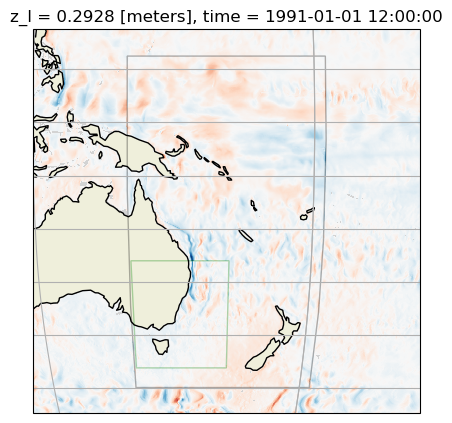

In [41]:
day = '1991-01-01'

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.Robinson(155), facecolor='lightgrey')

om2_sfc_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
sthpac_sfc_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
eac_sfc_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

box1 = patches.Rectangle((sthpac_idx['W'], sthpac_idx['S']), (sthpac_idx['E']-sthpac_idx['W']), 
                        (sthpac_idx['N']-sthpac_idx['S']), fill=None, transform=ccrs.PlateCarree(),
                        alpha=0.3)
box2 = patches.Rectangle((eac_idx['W'], eac_idx['S']), (eac_idx['E']-eac_idx['W']), 
                        (eac_idx['N']-eac_idx['S']), color='g', fill=None, transform=ccrs.PlateCarree(),
                        alpha=0.3)

ax.add_patch(box1); ax.add_patch(box2)
ax.add_feature(cfeature.LAND, zorder=0)
# p.axes.set_global()
ax.coastlines()
# ax.gridlines()

# define bounding box for zoomed in area
extent = [sthpac_idx['W']-20, sthpac_idx['E']+20, sthpac_idx['S']-5, sthpac_idx['N']+5]
ax.set_extent(extent, crs=ccrs.PlateCarree())

### Subset times to `minimum_range`

In [14]:
start_time = eac_v.time.min().values
end_time = '1992-12-31'

time_range = [str(start_time)[:10], str(end_time)[:10]]

sthpac = sthpac.sel(time=slice(start_time, end_time))

print(sthpac.time.min().values, sthpac.time.max().values)

om2_iaf = om2_iaf.sel(time=slice(str(start_time)[:10], str(end_time)[:10]))
print(om2_iaf.time.min().values, om2_iaf.time.max().values)


1990-11-01 12:00:00 1992-12-31 12:00:00
1990-11-01T12:00:00.000000000 1992-12-31T12:00:00.000000000


We won't subset down the datasets just yet as I'd ideally like to have that nesting-style plot that we had for the animation.

Next we need to subset spatial extent down to the smallest spatial extent which is the SRM (EAC-003) in this case. Let's get the coordinate limits of this and subset the PARENT and LRM models.

In [17]:
# spatial extent;
yextent = [eac.yh.min().values, eac.yh.max().values]
xextent = [eac.xh.min().values, eac.xh.max().values]
# subset PARENT AND LRM
access_daily = om2_iaf.sel(xu_ocean = slice(xextent[0], xextent[1]), 
                           yu_ocean = slice(yextent[0], yextent[1])).isel(st_ocean=0, st_edges_ocean=0)
sthpac = sthpac.sel(xq=slice(xextent[0], xextent[1]), 
                    xh=slice(xextent[0], xextent[1]),
                    yh=slice(yextent[0], yextent[1]),
                   yq = slice(yextent[0], yextent[1]))

print(f'sthpac new dims are: {sthpac.dims}')
print(f'access new dims are: {access_daily.dims}')

sthpac new dims are: Frozen({'yh': 253, 'z_l': 75, 'time': 851, 'xq': 214, 'xh': 215, 'yq': 252})
access new dims are: Frozen({'xu_ocean': 214, 'yu_ocean': 252, 'time': 851, 'nv': 2})


Right, so there's a fair bit of fiddling around when dealing with the three different grids. Surely we'll have to simplify things pretty soon...
### Using xgcm

Let's take a look at the bottom left portion of the array

In [43]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [185]:
sparseness = 10
eac_u_sparse = eac_u[0, ::sparseness, ::sparseness]
eac_v_sparse = eac_v[0, ::sparseness, ::sparseness]

In [186]:
# Define the target grid for interpolation
x_target = np.linspace(eac_u_sparse['xq'].min(), eac_u_sparse['xq'].max(), 100)
y_target = np.linspace(eac_u_sparse['yh'].min(), eac_u_sparse['yh'].max(), 100)
X_target, Y_target = np.meshgrid(x_target, y_target)

In [187]:
regridder = xesmf.Regridder(eac_u_sparse, {'lon':X_target, 'lat':Y_target}, 'bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_76x65_100x100.nc 
Reuse pre-computed weights? False 
Input grid shape:           (76, 65) 
Output grid shape:          (100, 100) 
Periodic in longitude?      False

In [188]:
u_target = regridder(eac_u_sparse)
v_target = regridder(eac_v_sparse)

In [ ]:
# Create the streamline plot
# plt.figure(figsize=(10, 8))
ax = plt.axes()#projection=ccrs.PlateCarree())
ax.streamplot(X_target, Y_target, u_target.values, v_target.values, density=2, color='b')#, transform=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
# ax.coastlines()

In [179]:
# eac_u_sparse = eac_u_sparse.rename({'yh':'lat','xq':'lon'})
eac_v_sparse = eac_v_sparse.rename({'yh':'lat', 'xq':'lon'})

ValueError: cannot rename 'yh' because it is not a variable or dimension in this dataset

In [180]:
eac_v_sparse

<xarray.DataArray 'vo' (yq: 76, xh: 65)>
dask.array<getitem, shape=(76, 65), dtype=float32, chunksize=(76, 65), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 0.2928
    time     object 1990-11-01 12:00:00
  * xh       (xh) float64 -219.5 -219.1 -218.8 -218.5 ... -198.8 -198.5 -198.1
  * yq       (yq) float64 -46.17 -45.94 -45.7 -45.47 ... -27.1 -26.8 -26.5 -26.2
Attributes:
    units:          m s-1
    long_name:      Sea Water Y Velocity
    cell_methods:   z_l:mean yq:point xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_y_velocity
    interp_method:  none

In [174]:
def sample_data(shape=(20, 30)):
    """
    Return ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned crs will be a rotated
    pole CRS, meaning that the vectors will be unevenly spaced in
    regular PlateCarree space.

    """
    import numpy as np

    crs = ccrs.PlateCarree()

#     x = np.linspace(311.9, 391.1, shape[1])
#     y = np.linspace(-23.6, 24.8, shape[0])

#     x2d, y2d = np.meshgrid(x, y)

    # Define the target grid for interpolation
    x_target = np.linspace(eac_u_sparse['xq'].min(), eac_u_sparse['xq'].max(), 100)
    y_target = np.linspace(eac_u_sparse['yh'].min(), eac_u_sparse['yh'].max(), 100)
    X_target, Y_target = np.meshgrid(x_target, y_target)
    
    regridder = xesmf.Regridder(eac_u_sparse, {'lon':X_target, 'lat':Y_target}, 'bilinear')
    
    u_target = regridder(eac_u_sparse)
    v_target = regridder(eac_v_sparse)
    # u = 10 * (2 * np.cos(2 * np.deg2rad(x2d) + 3 * np.deg2rad(y2d + 30)) ** 2)
    # v = 20 * np.cos(6 * np.deg2rad(x2d))

    return X_target, Y_target, u_target, v_target, crs


def main():
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-90, 75, 10, 85], crs=ccrs.PlateCarree())
    ax.coastlines()

    x, y, u, v, vector_crs = sample_data(shape=(80, 100))
    magnitude = (u ** 2 + v ** 2) ** 0.5
    ax.streamplot(x, y, u, v, transform=vector_crs,
                  linewidth=2, density=2, color=magnitude)
    plt.show()

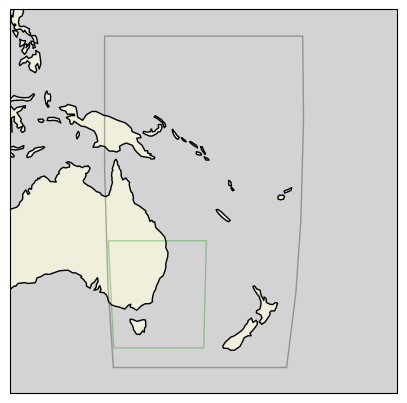

In [152]:
day = '1991-01-01'

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.Robinson(155), facecolor='lightgrey')

# ax.quiver(eac_u_sparse.xq, eac_u_sparse.yh, eac_u_sparse[0,:], eac_v_sparse[0,:], zorder=0, transform=ccrs.PlateCarree())

ax.streamplot(X_target, Y_target, u_target.values, v_target.values, density=2, color='b', transform=ccrs.PlateCarree(), zorder=0)


# om2_sfc_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
# sthpac_sfc_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
# eac_sfc_v.sel(time=day).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

box1 = patches.Rectangle((sthpac_idx['W'], sthpac_idx['S']), (sthpac_idx['E']-sthpac_idx['W']), 
                        (sthpac_idx['N']-sthpac_idx['S']), fill=None, transform=ccrs.PlateCarree(),
                        alpha=0.3)
box2 = patches.Rectangle((eac_idx['W'], eac_idx['S']), (eac_idx['E']-eac_idx['W']), 
                        (eac_idx['N']-eac_idx['S']), color='g', fill=None, transform=ccrs.PlateCarree(),
                        alpha=0.3)

ax.add_patch(box1); ax.add_patch(box2)
ax.add_feature(cfeature.LAND, zorder=0)
# p.axes.set_global()
ax.coastlines()
# ax.gridlines()

# define bounding box for zoomed in area
extent = [sthpac_idx['W']-20, sthpac_idx['E']+20, sthpac_idx['S']-5, sthpac_idx['N']+5]
ax.set_extent(extent, crs=ccrs.PlateCarree())

### Let's first just understand the process for EAC then we can quickly run this for STHPAC as well.

In [33]:
# Let's start with surface at this stage too
v_eac_sfc = da_dict['eac']['vo'].isel(z_l=0)
u_eac_sfc = da_dict['eac']['uo'].isel(z_l=0)

print(v_eac_sfc.dims, u_eac_sfc.dims)

('time', 'yq', 'xh') ('time', 'yh', 'xq')


In [35]:
# Interpolate v onto the u grid
v_eac_on_u = grid_dict['eac'].interp(v_eac_sfc, axis=['X', 'Y'])
v_eac_on_u

<xarray.DataArray 'vo' (time: 851, yh: 759, xq: 645)>
dask.array<transpose, shape=(851, 759, 645), dtype=float32, chunksize=(62, 759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

Now we've got these two variables, `u_eac_sfc` and `v_eac_on_u` that are both on the `(yh, xq)` grid, and thus can be used in calculations.

In [39]:
v_sfc_mean = v_eac_on_u.mean('time')
v_sfc_mean

<xarray.DataArray 'vo' (yh: 759, xq: 645)>
dask.array<mean_agg-aggregate, shape=(759, 645), dtype=float32, chunksize=(759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

In [58]:
new_end_time = '1992-12-31'

In [62]:
time_range[1] = new_end_time
time_range

['1990-11-01', '1992-12-31']

In [63]:
v_eac_on_u = v_eac_on_u.sel(time=slice(time_range[0], time_range[1]))
u_eac_sfc = u_eac_sfc.sel(time=slice(time_range[0], time_range[1]))
v_eac_on_u

<xarray.DataArray 'vo' (time: 792, yh: 759, xq: 645)>
dask.array<getitem, shape=(792, 759, 645), dtype=float32, chunksize=(62, 759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * time     (time) object 1990-11-01 12:00:00 ... 1992-12-31 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

In [65]:
%%time
v = v_eac_on_u.compute()
u = u_eac_sfc.compute()

CPU times: user 24.2 s, sys: 1min 43s, total: 2min 7s
Wall time: 3min 35s


In [66]:
%%time
v_mean = v.mean('time').compute()
u_mean = u.mean('time').compute()

CPU times: user 14.4 s, sys: 1min 15s, total: 1min 29s
Wall time: 1min 14s


In [67]:
%%time
u_transient = u - u_mean
v_transient = v - v_mean

Perhaps this is something best done with the MONTHLY DATA.

In [68]:
%%time
EKE = (0.5*(u_transient**2 + v_transient**2)).compute()
EKE

CPU times: user 11.8 s, sys: 1min 7s, total: 1min 19s
Wall time: 1min 5s


<xarray.DataArray (time: 792, yh: 759, xq: 645)>
array([[[           nan,            nan,            nan, ...,
         1.14616863e-02, 1.25303958e-02,            nan],
        [7.57145835e-03, 1.88145554e-03, 1.04965398e-03, ...,
         2.57341396e-02, 3.59266698e-02, 2.34802272e-02],
        [1.04822544e-02, 2.02735839e-03, 6.60893042e-04, ...,
         2.33535562e-02, 3.64572778e-02, 2.21329685e-02],
        ...,
        [           nan,            nan,            nan, ...,
         8.92650802e-03, 9.61241219e-03,            nan],
        [           nan,            nan,            nan, ...,
         1.03009809e-02, 9.99290310e-03,            nan],
        [           nan,            nan,            nan, ...,
         8.53654742e-03, 8.06551985e-03,            nan]],

       [[           nan,            nan,            nan, ...,
         6.59720879e-03, 1.91662449e-03,            nan],
        [2.01843656e-03, 1.32023619e-04, 7.00478733e-04, ...,
         5.06769866e-03, 1.93163415e-03, 4.79919650e-03],
        [1.75116141e-03, 1.45069242e-03, 6.20515610e-04, ...,
         3.74552933e-03, 1.19214668e-03, 5.25289401e-03],
...
        [           nan,            nan,            nan, ...,
         2.14666575e-02, 3.47604938e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.28590723e-02, 3.42348292e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.55962629e-02, 3.26998830e-02,            nan]],

       [[           nan,            nan,            nan, ...,
         1.44427996e-02, 1.21968426e-02,            nan],
        [2.57358067e-02, 2.54580751e-02, 2.85354555e-02, ...,
         5.45563316e-03, 3.24787991e-03, 1.84880360e-03],
        [2.65089907e-02, 2.56797578e-02, 2.86915805e-02, ...,
         4.53792885e-03, 2.22274335e-03, 9.87250241e-05],
        ...,
        [           nan,            nan,            nan, ...,
         2.10243650e-02, 3.57130654e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.32815370e-02, 3.59133594e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.76880525e-02, 3.76227386e-02,            nan]]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
    z_l      float64 0.2928
  * time     (time) object 1990-11-01 12:00:00 ... 1992-12-31 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

**If interested in depth-integrated EKE...**

In [ ]:
EKE_ztotal = EKE.sum('z_l')
EKE_ztotal

Text(0.5, 1.0, 'Eddy Kinetic Energy')

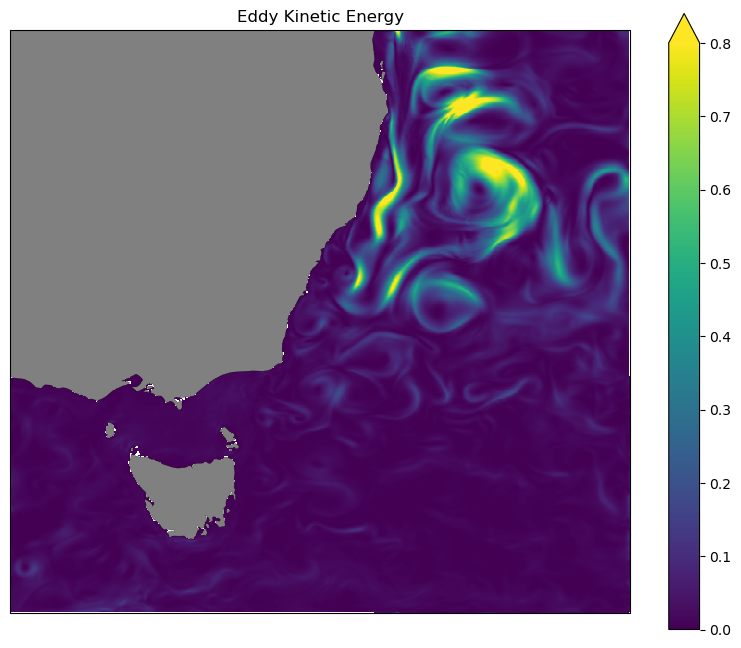

In [75]:
data = EKE
title = 'Eddy Kinetic Energy'
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude=170))

data[100,:].plot(ax=ax, transform=ccrs.PlateCarree(),vmax=0.8)

ax.add_feature(land_50m)
# ax.add_outline_patch.set_linewidth(0.5)
ax.set_title(title)

In [76]:
EKE_mean = EKE.mean('time')

Text(0.5, 1.0, 'Eddy Kinetic Energy')

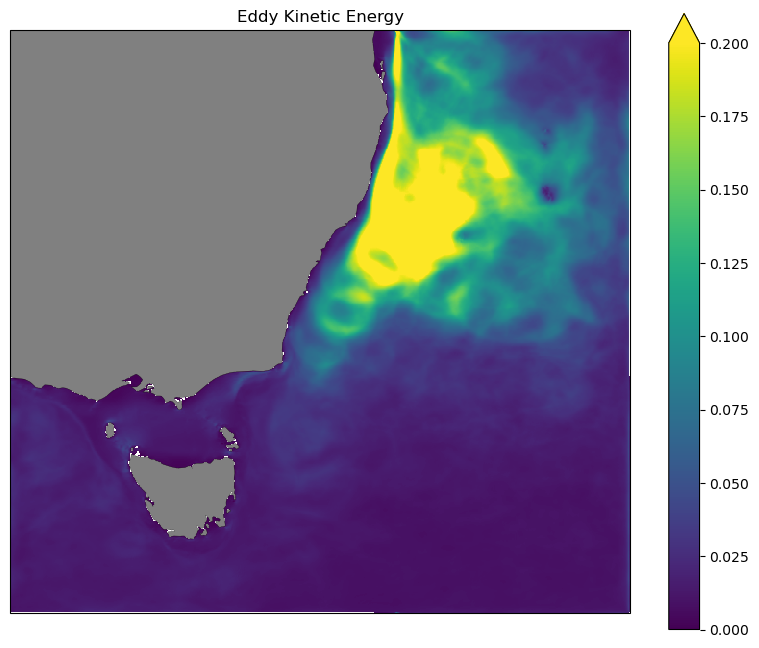

In [79]:
data = EKE_mean
title = 'Eddy Kinetic Energy'
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude=170))

data.plot(ax=ax, transform=ccrs.PlateCarree(),vmax=0.2)

ax.add_feature(land_50m)
# ax.add_outline_patch.set_linewidth(0.5)
ax.set_title(title)

In [82]:
EKE_std = EKE.std('time')

Text(0.5, 1.0, 'Eddy Kinetic Energy')

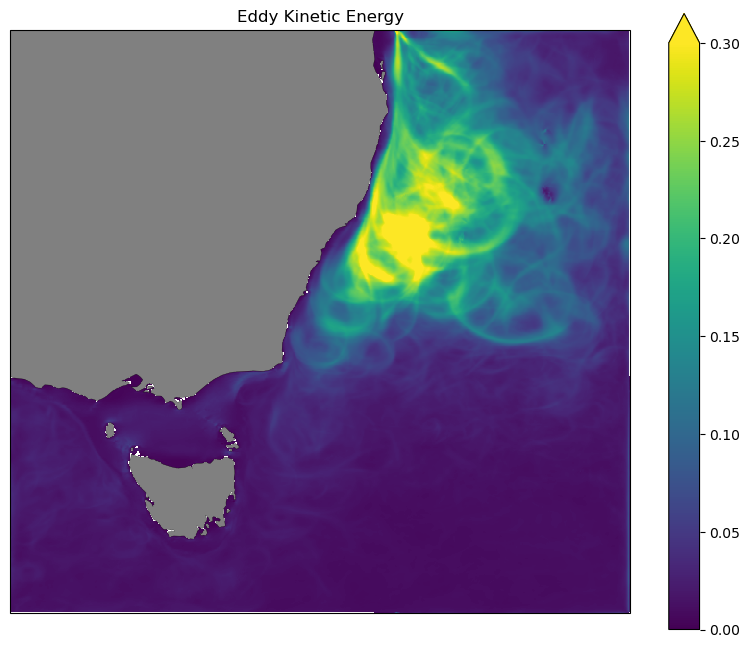

In [85]:
data = EKE_std
title = 'Eddy Kinetic Energy'
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude=170))

data.plot(ax=ax, transform=ccrs.PlateCarree(),vmax=0.3)

ax.add_feature(land_50m)
# ax.add_outline_patch.set_linewidth(0.5)
ax.set_title(title)

Perhaps now is a good time to make a quick overview plot that has mean velocities as arrows, and temp/sea-level anomaly as shading.